# Nodebook - Playing with OpenAI APIs

## Prerequisites

### Node.js packages

`sh` function to replace magic command.

In [ ]:
var { spawn } = require('child_process');
var sh = (cmd) => {
    $$.async();
    var sp = spawn(cmd, { cwd: process.cwd(), stdio: 'pipe', shell: true, encoding: 'utf-8' });
    sp.stdout.on('data', data => console.log(data.toString()));
    sp.stderr.on('data', data => console.error(data.toString()));
    sp.on('close', () => $$.done());
};

Node.js modules installation
- [esm-hook](https://www.npmjs.com/package/esm-hook) to use ESM modules with zero setup
- [dotenv](https://www.npmjs.com/package/dotenv) to load environment variables from .env file
- [openai](https://www.npmjs.com/package/openai) the official binding library for OpenAI APIs
- [LangChain](https://js.langchain.com/) the Javascript version of the wellknown AI framework

In [ ]:
sh('npm install esm-hook dotenv openai langchain');

### OpenAI API key

To access OpenAI APIs, a paid account and an [API key](https://platform.openai.com/account/api-keys) are required.

We store the key in a **.env** file located in the notebook folder with an entry like this:

```bash
GPT_KEY=sk-<the-rest-of-your-OpenAI-key>
```

We then load it into the execution context.

In [ ]:
var dotenv = require("dotenv");
dotenv.config();

if (process.env.GPT_KEY) console.log("API key loaded");

## Abstraction levels
There are several methods for interacting with OpenAI APIs with varying degrees of abstraction. 

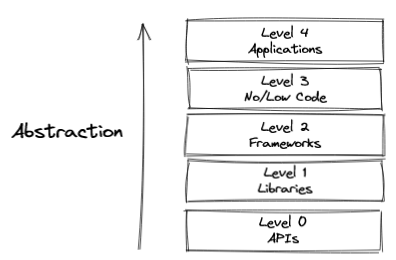

Let's visit the three first levels.

## Level 0 - Direct API calls

Let's start with **level 0 abstraction** and call OpenAI API directly from Node.js. 

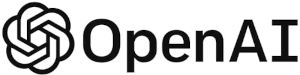

### The OpenAI APIs

There are two different APIs to interact with GPT models: the Completion API is more general-purpose and suitable for single-turn tasks, whereas the ChatCompletion API is tailored for interactive, multi-turn conversations.
- **Completion API**: This is primarily used for generating text based on a given prompt. It is designed to extend or "complete" the input text by generating relevant and coherent content. The input is generally a single string, which serves as a prompt for the model. This APi is now deprecated.
- **ChatCompletion API**: This is designed specifically for multi-turn conversations. It facilitates back-and-forth interactions with the model, allowing users to have more dynamic and interactive conversations. The input is structured as a series of messages in a conversation format. Each message has two properties: *role* (which can be 'system', 'user', or 'assistant') and *content* (which contains the text of the message).

OpenAI also provides an **Embeddings API** that measures the relatedness of text strings. Embedding is a technique to incorporate new snippets of knowledge (embeds) at runtime into an already existing model. To do so, the text snippets must be converted into numerical vectors by the model. The distance between two vectors measures their relatedness. Small distances suggest high relatedness and large distances suggest low relatedness.

### Chat Completion API

Let's begin with a simple call to the Chat Completion API.

In [ ]:
// Call the Chat Completion API
fetch('https://api.openai.com/v1/chat/completions', {
  method: "POST",
  headers: { 
    "Content-Type": "application/json",
    "Authorization": "Bearer " + process.env.GPT_KEY,
  },
  body: JSON.stringify({
    model: "gpt-4",
    messages: [
      { "role": "system", "content": "You are a helpful assistant." },
      { "role": "user", "content": "Say hello in French" }
    ]
  })
})
  .then((response) => response.json())
  .then((json) => console.log(json.choices[0].message));


### Embeddings API

Now we call the Embeddings API to get the vector associated with a specific text.

The model to use is different and called *text-embedding-ada-002*.

In [ ]:
// Call the Embeddings API
fetch('https://api.openai.com/v1/embeddings', {
  method: "POST",
  headers: { 
    "Content-Type": "application/json",
    "Authorization": "Bearer " + process.env.GPT_KEY,
  },
  body: JSON.stringify({
    model: "text-embedding-ada-002",
    encoding_format: "float",
    input: "The GenAI's Lamp makes your whises come true!"
  })
})
  .then((response) => response.json())
  .then((json) => console.log(json.data[0].embedding));

Cool. We note that the return vector has 1536 dimensions as expected from OpenAI.

### Image Generation API

Let's get more visual and ask the OpenAI DALL-E 3 model to create a image.

In [ ]:
var image = $$.display("image");

// Call the Embeddings API
fetch('https://api.openai.com/v1/images/generations', {
  method: "POST",
  headers: { 
    "Content-Type": "application/json",
    "Authorization": "Bearer " + process.env.GPT_KEY,
  },
  body: JSON.stringify({
    model: "dall-e-3",
    n: 1,
    size: "1024x1024",
    prompt: "A robotic genie coming out of a magic lamp"
  })
})
  .then((response) => response.json())
  .then((json) => image.html("<img src='"+ json.data[0].url +"' width='400' height='400'>"));

## Level 1 - Using the *openai* module

The *openai* module is basically a wrapper to call OpenAI APIs from Node.js. SIne the code is quite similar to direct API calls with the fetch method, let's illustrate it's use with a Chat Completion.

In [ ]:
var { Configuration, OpenAIApi } = require("openai");

var configuration = new Configuration({
  apiKey: process.env.GPT_KEY,
});
var openai = new OpenAIApi(configuration);

async function runCompletion() {
    var completion = await openai.createChatCompletion({
        model: "gpt-4",
        messages: [
            { role: "system", content: "You are a helpful assistant." },
            { role: 'user', content: 'Why is the sky blue?' }
        ],
    });
    console.log(completion.data.choices[0].message.content);
}

runCompletion();

The code to get embeddings and generate images is quite similar but with use of the `openai.embeddings.create` or the `openai.images.generate` functions with the same parameters as in the direct API calls.

## Level 2 - Using the *LangChain* framework

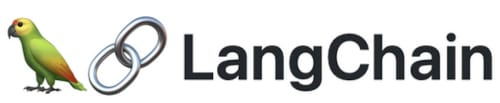

We now use a **level 2 abstraction** framework, [LangChain](https://js.langchain.com/), to call Completion and ChatCompletion OpenAI APIs.

### Chat Completion

In [ ]:
var { ChatOpenAI } = require ("langchain/chat_models/openai");
var { HumanMessage } = require ("langchain/schema");

// Access to ChatCompletion API
var chat = new ChatOpenAI({
  openAIApiKey: process.env.GPT_KEY,
  modelName: "gpt-4"
});

async function getChatCompletion(prompt) {
  var messages = [new HumanMessage({ content: prompt })];
  var res = await chat.call(messages);
  console.log(res.content);
}

In [ ]:
getChatCompletion("Say hello in Swahili");

In [ ]:
getChatCompletion("Say hello in Swedish");

### Embeddings
Now let's try again to call the Embedding API.

In [ ]:
var { OpenAIEmbeddings } = require ("langchain/embeddings/openai");

var embeddings = new OpenAIEmbeddings({
  openAIApiKey: process.env.GPT_KEY,
  modelName: "text-embedding-ada-002"
});

async function getEmbedding() {
  var res = await embeddings.embedQuery("The TechSquad is Worldline's DevRel initiative");
  console.log(res);
}

getEmbedding();

So far we kept asking OpenAI to return embedding vectors, let's do something with them.

### Retrieval Augmented Generation (RAG)

A particularly interesting application is using embeddings to gauge similarities between words or sentences. The idea of the RAG technique is to add new snippets of knowledge to the model by injecting them in the prompt at runtime. 

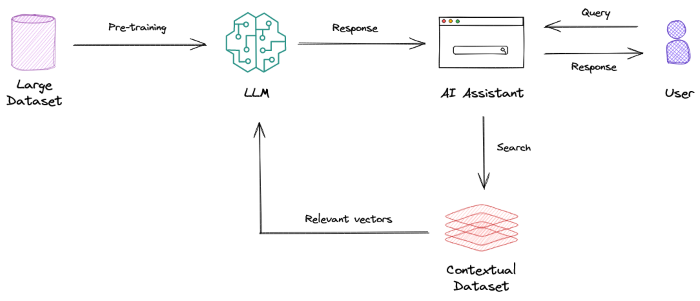

So before calling a Completion API, we need to first retrieve relevant information from local sources (like documents for instance) based on the user prompt.

Let's explore and implement this technique with one single PDF document.

First we need to index the document by calling the *Embedding API* of OpenAI and storing the returns vectors locally since they are not kept by the model:
- Split the document's content in chunks
- Call the Embedding API for each chunk
- Store each returned vector into a local database (called vectorstore)

Here we use the lightweight, in-memory and ephemeral vectorstore proposed by LangChain. The framework provides the appropriate abstraction level to implement the three listed tasks with very few instructions.

In [ ]:
var { MemoryVectorStore } = require ("langchain/vectorstores/memory");
var { PDFLoader } = require("langchain/document_loaders/fs/pdf");
var { RetrievalQAChain } = require("langchain/chains");

async function getPDFCompletion() {
  //Load our local PDF document
  var loader = new PDFLoader("TechSquad.pdf");
  var docs = await loader.load();
    
  //Create a vector store from the embeddings
  var vectorStore = await MemoryVectorStore.fromDocuments(
    docs,
    embeddings
  );
    
  // Create a chain that uses the OpenAI LLM and our vector store
  var chain = RetrievalQAChain.fromLLM(
    chat, 
    vectorStore.asRetriever()
  );
    
  var res = await chain.call({
    query: "What are the ambition and objectives of the TechSquad?"
  });
    
  console.log(res.text);
}

getPDFCompletion();

Neat!
    
We'll visit abstraction levels 3 and 4 in more upcoming videos so stay tuned!

## Thank you!